# Проверка гипотез для увеличения выручки интернет-магазина.

Цели исследования:  
Приоритизировать гипотезы.  
Проанализировать результаты A/B-теста.  
Принять решение о продолжении/остановке A/B-теста.

## Предобработка данных

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mt
import itertools

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.info()
display(hypothesis.describe(include = 'all').T)
display(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Hypothesis,9,9,"Запустить акцию, дающую скидку на товар в день...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reach,9.0,NaN,NaN,NaN,4.777778,3.153481,1.0,3.0,3.0,8.0,10.0
Impact,9.0,NaN,NaN,NaN,4.777778,3.192874,1.0,3.0,3.0,7.0,10.0
Confidence,9.0,NaN,NaN,NaN,5.555556,3.045944,1.0,3.0,7.0,8.0,9.0
Efforts,9.0,NaN,NaN,NaN,4.888889,2.803767,1.0,3.0,5.0,6.0,10.0


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


В данных нет пропусков и дубликатов. В столбце Hypothesis некоторые строки начинаются с лишних пробелов. Анализу это не мешает. Оставляю без изменений.

In [3]:
orders = pd.read_csv('/datasets/orders.csv')
orders.info()
display(orders.describe(include = 'all').T)
display(orders.sample(5, random_state=42))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
transactionId,1197.0,NaN,NaN,NaN,2155621385.529657,1229084904.760058,1062393.0,1166775572.0,2145193898.0,3237740112.0,4293855558.0
visitorId,1197.0,NaN,NaN,NaN,2165960143.099415,1236014192.14687,5114589.0,1111826046.0,2217984702.0,3177606451.0,4283872382.0
date,1197,31,2019-08-05,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
revenue,1197.0,NaN,NaN,NaN,8348.005848,39191.131774,50.0,1220.0,2978.0,8290.0,1294500.0
group,1197,2,B,640,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,transactionId,visitorId,date,revenue,group
921,3102219893,151496413,2019-08-21,350,A
321,1775445570,3118528100,2019-08-19,1090,A
101,3847160695,1830791924,2019-08-01,2350,A
920,3057892078,249864742,2019-08-21,5530,B
58,2145193898,1221478247,2019-08-16,1440,B


In [4]:
display(orders.duplicated().sum())
display(len(orders['transactionId'].unique()))

0

1197

В данных нет пропусков и явных дубликатов. У столбца 'date' неверный тип данных. Изменим

In [5]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [6]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.info()
visitors.describe(include = 'all').T
visitors.sample(5, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
50,2019-08-20,B,560
56,2019-08-26,B,676
0,2019-08-01,A,719
57,2019-08-27,B,720
5,2019-08-06,A,667


В данных нет пропусков и явных дубликатов. У столбца 'date' неверный тип данных. Скорректируем

In [7]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [8]:
display(orders['group'].value_counts())

B    640
A    557
Name: group, dtype: int64

По количеству по количеству заказов группа В превышает А.  
Проверим, есть ли заказы у кого-то из покупателей сразу в двух группах.

In [9]:
check = orders.pivot_table(index='visitorId', values='group', aggfunc='nunique').reset_index()
len(check[check['group'] > 1])

58

58 клиентов, совершивших заказ, попали в обе тестовые группы. Это около 5% от общего числа уникальных пользователей.  
Информацию по таким клиентам возможно удалить из базы с заказами, но не из данных по посещениям, так как они прдставлены в сгруппированном виде, без указаний id клиента.  
Оставим данные без изменения.

В исходных данных нет нулевых значений и дубликатов.  
Был изменён тип данных для столбцов date в датасетах orders и visitors

## Приоритизация гипотез

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [10]:
pd.set_option('display.max_colwidth', 0)
hypothesis['ICE'] = np.round((hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts'], 1)
hypothesis.sort_values(by = 'ICE', ascending = False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


In [11]:
display('Гипотезы, получившие наибольшие баллы:', hypothesis.sort_values(by = 'ICE', ascending = False)['Hypothesis'].head(4))

'Гипотезы, получившие наибольшие баллы:'

8    Запустить акцию, дающую скидку на товар в день рождения                                             
0    Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  
7    Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок    
6    Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
Name: Hypothesis, dtype: object

Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [12]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis.sort_values(by = 'RICE', ascending = False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


In [13]:
display('Гипотезы, получившие наибольшие баллы по методу RICE:', hypothesis.sort_values(by = 'RICE', ascending = False)['Hypothesis'].head(4))

'Гипотезы, получившие наибольшие баллы по методу RICE:'

7    Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок            
2    Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
0    Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей          
6    Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию        
Name: Hypothesis, dtype: object

Во втором методе в расчёте приоритета учитывается оценка охвата аудитории, на которую повлияют возможные изменения. Соответственно изменяется общая оценка гипотез.

## Анализ A/B-теста

In [14]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(20)) 

         date group  orders  buyers  revenue  visitors
0  2019-08-01  A     24      20      148579   719     
1  2019-08-01  B     21      20      101217   713     
2  2019-08-02  A     44      38      242401   1338    
3  2019-08-02  B     45      43      266748   1294    
4  2019-08-03  A     68      62      354874   1845    
5  2019-08-03  B     61      59      380996   1803    
6  2019-08-04  A     84      77      425699   2562    
7  2019-08-04  B     78      75      489567   2573    
8  2019-08-05  A     109     100     549917   3318    
9  2019-08-05  B     101     98      581995   3280    
10 2019-08-06  A     127     114     598401   3985    
11 2019-08-06  B     129     123     824337   3935    
12 2019-08-07  A     145     131     740818   4629    
13 2019-08-07  B     153     146     1049671  4644    
14 2019-08-08  A     161     146     837097   5239    
15 2019-08-08  B     180     171     1270589  5298    
16 2019-08-09  A     177     159     1025603  5856    
17 2019-08

### Построение графиков

Построим график кумулятивной выручки по группам.

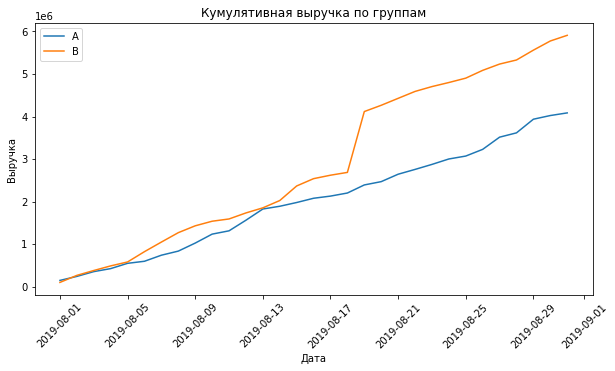

In [15]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

fig, ax = plt.subplots(figsize=(10, 5))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.show()

Выручка группы А равномерно увеличивается в течение всего теста.  
Лидером на протяжении теста остаётся группа В. Но у графика есть резкий рост.
Это может означать, что в выборке появился очень доогой заказ, либо резкий рост количества заказов.  

Построим график кумулятивного среднего чека по группам.

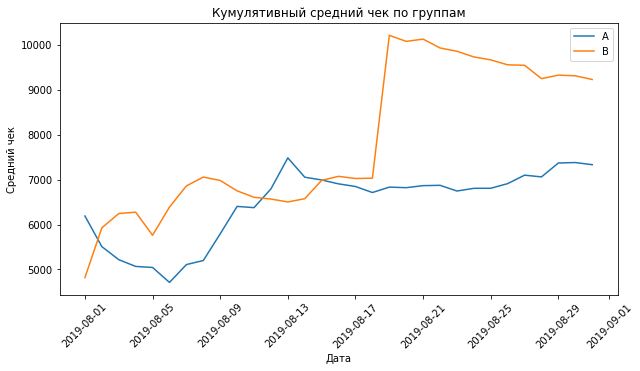

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.xticks(rotation=45)
plt.show()

График по среднему чеку становится более равномерным к середине теста:  
Небольшой рост у группы А и плавное снижение (после резкого роста) у группы В.  
Можно предположить, что в группу В попал очень крупный заказ. 

Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

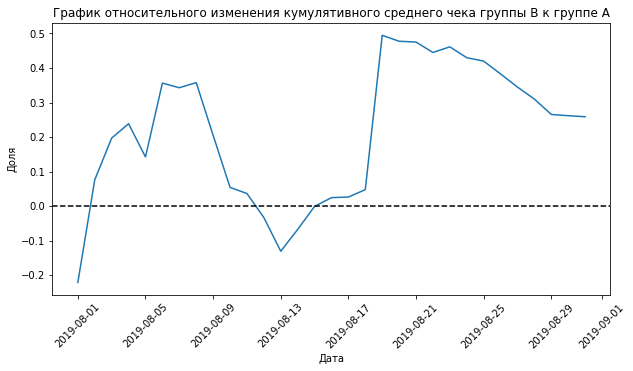

In [17]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

fig, ax = plt.subplots(figsize=(10, 5))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Доля')
plt.xticks(rotation=45)
plt.show()

Результаты теста значительно и резко менялись в несколько дат. Вероятно, в эти дни были сделаны аномальные заказы. 

Построим график кумулятивного среднего количества заказов на посетителя по группам. 

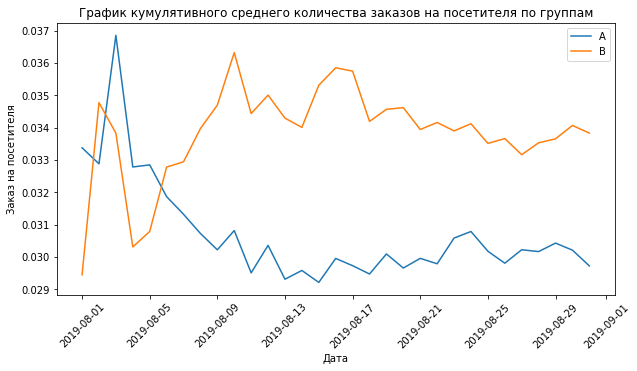

In [18]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Заказ на посетителя')
plt.xticks(rotation=45)
plt.show()

После небольших всплесков в начале теста, количество заказов на пользователя и по группе А, и по группе В выравнялась.  

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

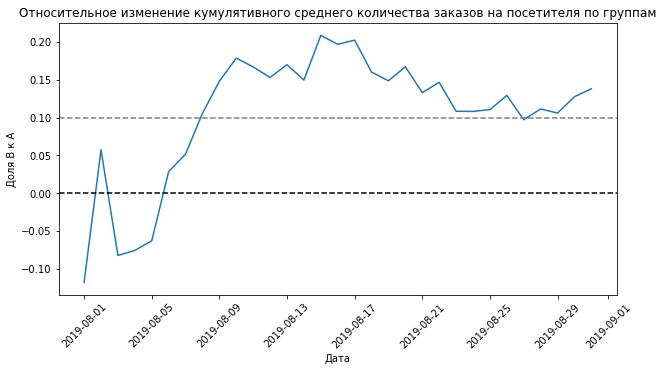

In [19]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Доля В к А')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.show()

Количество заказов на посетитля в группе В практически на протяжнии всего текущего теста лучше группы А на 10%. 

Построим точечный график количества заказов по пользователям. 

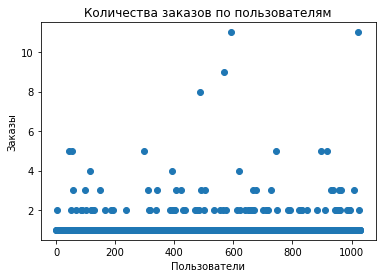

In [20]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorId', 'orders']

x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Заказы')
plt.show()

Большинство покупателей делает только один заказ. Много пользователей с 2-4 заказами. Есть клиенты, сделавшие более 10 заказов.   
Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [21]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 2., 4.])

Только 5% пользователей делает больше двух заказов. И только у 1% их больше 4.  
Выберем 3 заказа на пользователся в качестве верхней границы. Всё, что выше можно признать аномальными значениями. 

Построим точечный график стоимостей заказов.

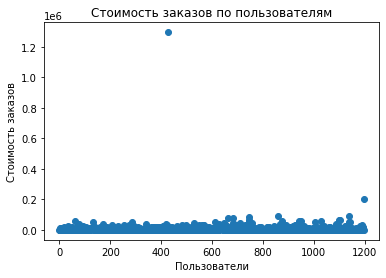

In [22]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')
plt.show()

Очень явно выделяется 2 точки - около 20 тыс.руб и свыше 1.2 млн. Большая часть заказов не превышает и 10 тыс. рублей.  

Ограничим масштаб графика по стоимости заказа верхней границей 50 тыс. руб

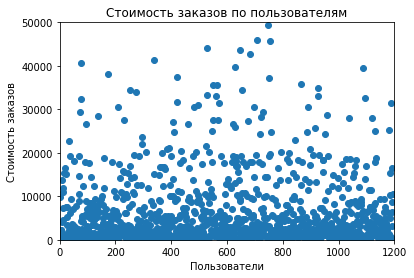

In [23]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.axis([0, 1200, 0, 50000])
plt.title('Стоимость заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')
plt.show()

По графику распределения визуально можно оценить, что основная часть заказов по стоимости ниже 10 тыс руб. Тем не менее есть довольна больша часть, которая лежит в пределах 20 тыс.руб.

Посчитайте 95-й и 99-й перцентили стоимости заказов. 

In [24]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

Как и предполагалось, только 5% заказов превышают стоимость 28000. Эту сумму и возьмём в качестве верхней границы, для того чтобы отсеять аномальные значения.

### Расчёт статистической значимости

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.  
Сформулируем гипотезы.  
Нулевая: различий в среднем количестве заказов между группами нет.  
Альтернативная: различия в среднем между группами есть.

Уровень значимости зададим 5%

In [25]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value', "{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value 0.017
0.138


P-value меньше 0.05. Значит нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, подтвердить не можем. По «сырым» данным в среднем числе заказов групп A и B есть различия. Относительный прирост среднего группы В составляет 13.8%

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.  
Нулевая гипотеза: различий в среднем чеке между группами нет.  
Альтернативная гипотеза: различия в среднем чеке между группами есть.  
Уровень значимости зададим 5%

In [26]:
print('p-value', '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value 0.729
0.259


P-value значительно больше 0.05. Значит, отвергнуть нулевую гипотезу и считать, что в среднем чеке есть различия, не можем. Относительный прирост среднего чека группы В - 25,9% 

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.  
Ранее мы выбрали 3 заказа на пользователя в качестве верхней границы. А так же средний чек свыше 28000 руб.  
Нулевая: по отфильтрованным данным различий в среднем количестве заказов между группами нет.  
Альтернативная: по отфильтрованным данным различия в среднем между группами есть.  
Уровень значимости 5%

In [27]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

#Применим статистический критерий Манна-Уитни к полученным выборкам
print('p-value', '{0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value 0.018
0.148


Результаты по среднему количеству заказов относительно "сырых" данных практически не изменились. 
На 1% увеличился относительный прирост группы В к А

Посчитайем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.  
Нулевая гипотеза: по отфильтрованным данным различий в среднем чеке между группами нет. 
Альтернативная гипотеза: по отфильтрованным данным различия в среднем чеке между группами есть. 
Уровень значимости зададим 5%

In [28]:
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.977
-0.017


P-value увеличился. Исключив аномальные значения, мы получили изменения разницы в среднем чеке между группами А и В

## Вывод

Анализ "сырых данных" позволяет предположить: 
В среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы В составляет 13.8%  
Статистически значимых различий в среднем чеке нет.  
Согласно анализу данных, очищенных от аномалий и выбросов:
По количеству заказов между группами подтвердилась статистически значимые различия. Относительный приросто группы В увеличился на 14,8%.  
По среднему чеку так же подтвердилось отсутствиея статистически значимых различий. Но выявлено, что средний чек сегмента В немного ниже сегмента А. 

Мы видим прирост по количеству заказов на посетителя в группе В и отсутствие изменений в среднем чеке. Следует остановить тест и признать, что сегмет В лучше А.